<a href="https://colab.research.google.com/github/Mushrifah/sentiment_analysis/blob/master/svm_model_for_imdb_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1TgsnApIgUGzC1pd9RYkCFoSP0yFEuXVJ

file_id = '1TgsnApIgUGzC1pd9RYkCFoSP0yFEuXVJ' #-- Updated File ID for my zip
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('movie_reviews.csv')

    100% |████████████████████████████████| 993kB 27.9MB/s 


In [2]:
import pandas as pd

df=pd.read_csv("movie_reviews.csv",encoding="utf8")
df.head()

,review,sentiment
0,"I have done a lot of international travel, bot...",positive
1,One of the most frightening game experiences e...,positive
2,I was amazingly impressed by this movie. It co...,positive
3,"This film is stale, and misses the mark. It is...",negative
4,At last!! Sandra Bullock is indeed a beautiful...,positive


In [3]:
df = df[df.sentiment != 'unsup']
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,"I have done a lot of international travel, bot...",1
1,One of the most frightening game experiences e...,1
2,I was amazingly impressed by this movie. It co...,1
3,"This film is stale, and misses the mark. It is...",0
4,At last!! Sandra Bullock is indeed a beautiful...,1


In [4]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
df['Processed_Reviews'][0]

"lot international travel business tourist type assure best advice also oldest always drink wine country movie archangel michael come earth business wrap quickly decide hang around little tour boy doe drink wine countrybr br could man drink forever liquor love fight br br hed lief rise morning lief lie nightsbr br thing cant heaven enjoy he's here! course turn couple job tackle and, le direct wa first one, successful. final scene little schmaltzy also wonderful. jean stapleton get dance john travolta."

In [6]:
df['review'][0]

'I have done a lot of international travel, both on business and as a tourist. For both types I assure you the best advice is also the oldest: Always drink the wine of the country. In this movie the archangel Michael comes to Earth on business, wraps it up quickly and decides to hang around for a little touring. Boy! Does he "drink the wine of the country."<br /><br />Could man be drunk forever with liquor, love and fights <br /><br />He\'d lief rise up of mornings and lief lie down of nights.<br /><br />These are things you can\'t do in Heaven so he enjoys them while he\'s here! Of course it turns out he had a couple of other jobs to tackle and, if he is less direct about them than he was about the first one, he is just as successful. The final scene is a little schmaltzy but it is also wonderful. Jean Stapleton gets to dance with John Travolta.'

In [7]:
df.head()

,review,sentiment,Processed_Reviews
0,"I have done a lot of international travel, bot...",1,lot international travel business tourist type...
1,One of the most frightening game experiences e...,1,one frighten game experience ever make keep li...
2,I was amazingly impressed by this movie. It co...,1,wa amazingly impress movie contain fundamental...
3,"This film is stale, and misses the mark. It is...",0,film stale miss mark far compare 89 batman try...
4,At last!! Sandra Bullock is indeed a beautiful...,1,last sandra bullock indeed beautiful woman ive...


In [8]:
df = df.drop(['review'],axis=1)
df.head()

,sentiment,Processed_Reviews
0,1,lot international travel business tourist type...
1,1,one frighten game experience ever make keep li...
2,1,wa amazingly impress movie contain fundamental...
3,0,film stale miss mark far compare 89 batman try...
4,1,last sandra bullock indeed beautiful woman ive...


In [0]:
trd = df[:35000]
ted = df[35000:]

In [0]:
import numpy as np

train_reviews = np.array(trd['Processed_Reviews'])
train_sentiments = np.array(trd['sentiment'])
test_reviews = np.array(ted['Processed_Reviews'])
test_sentiments = np.array(ted['sentiment'])

In [11]:
sample_docs = [100, 5817, 7626, 7356, 1008, 7155, 3533, 13010]
sample_data = [(test_reviews[index],
                test_sentiments[index])
                  for index in sample_docs]

sample_data  

[('third entry stepford franchise apparently three madefortv obscure sequel incredibly obscure hard trace whereas 70 original well blockbuster remake nicole kidman commonly know popular havent see either early 80 revenge stepford wife mid 90 stepford husband stepford child quite charm highly entertain little film basically exact film original obviously le mysterious yet much cheesier incredibly 80 nth degree main difference like title imply liberate wife also rebellious punk teenage offspring town undergo typical highly effective stepford treatment license local men association reason scenario attempt uphold stepford mystery late film even though nobody likely watch sequel check original presumably everybody also know denouement harding family pack ready move grisly city new york small peaceful community stepford. particularly father steven excite new life already live stepford always want go back ever since first wife, new wife laura adolescent child mary david know little about, die 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def build_feature_matrix(documents, feature_type='frequency',
                         ngram_range=(1, 1), min_df=0.0, max_df=1.0):

    feature_type = feature_type.lower().strip()  
    
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, 
                                     ngram_range=ngram_range)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix

In [0]:
vectorizer=TfidfVectorizer(ngram_range=(1, 1), min_df=0.0, max_df=1.0)

In [0]:
vectorizer, train_features = build_feature_matrix(documents=train_reviews,
                                                  feature_type='tfidf',
                                                  ngram_range=(1, 1), 
                                                  min_df=0.0, max_df=1.0)                                      
                                      

In [15]:
from sklearn.linear_model import SGDClassifier
# build the model
svm = SGDClassifier(loss='hinge', n_iter=500)
svm.fit(train_features, train_sentiments)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
test_features = vectorizer.transform(test_reviews) 

In [17]:
for doc_index in sample_docs:
    print ('Review:-')
    print (test_reviews[doc_index])
    print ('Actual Labeled Sentiment:', test_sentiments[doc_index])
    doc_features = test_features[doc_index]
    predicted_sentiment = svm.predict(doc_features)[0]
    print ('Predicted Sentiment:', predicted_sentiment)
    print("")

Review:-
third entry stepford franchise apparently three madefortv obscure sequel incredibly obscure hard trace whereas 70 original well blockbuster remake nicole kidman commonly know popular havent see either early 80 revenge stepford wife mid 90 stepford husband stepford child quite charm highly entertain little film basically exact film original obviously le mysterious yet much cheesier incredibly 80 nth degree main difference like title imply liberate wife also rebellious punk teenage offspring town undergo typical highly effective stepford treatment license local men association reason scenario attempt uphold stepford mystery late film even though nobody likely watch sequel check original presumably everybody also know denouement harding family pack ready move grisly city new york small peaceful community stepford. particularly father steven excite new life already live stepford always want go back ever since first wife, new wife laura adolescent child mary david know little about

In [18]:
svm.score(test_features,test_sentiments)

0.895

In [19]:
predicted_sentiments = svm.predict(test_features) 
predicted_sentiments

array([1, 1, 0, ..., 1, 1, 0])

In [0]:
from sklearn import metrics

def display_evaluation_metrics(true_labels, predicted_labels, positive_class=1):
    
    print ('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        2))
    print ('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))
    print ('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))
    print ('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               pos_label=positive_class,
                                               average='binary'),
                        2))
                        
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    cm = metrics.confusion_matrix(y_true=true_labels, 
                                  y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=[[0,0],[0,1]]), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=[[0,0],[0,1]])) 
    print( cm_frame)                            


def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print (report)

In [21]:
display_evaluation_metrics(true_labels=test_sentiments,
                           predicted_labels=predicted_sentiments,
                           positive_class=1)  
                           

Accuracy: 0.9
Precision: 0.88
Recall: 0.91
F1 Score: 0.9


In [22]:
display_confusion_matrix(true_labels=test_sentiments,
                         predicted_labels=predicted_sentiments,
                         classes=[1, 0])
                         


          Predicted:      
                   1     0
Actual: 1       6827   645
        0        930  6598


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead


In [23]:
display_classification_report(true_labels=test_sentiments,
                              predicted_labels=predicted_sentiments,
                              classes=[1, 0]) 

              precision    recall  f1-score   support

           1       0.88      0.91      0.90      7472
           0       0.91      0.88      0.89      7528

   micro avg       0.90      0.90      0.90     15000
   macro avg       0.90      0.90      0.89     15000
weighted avg       0.90      0.90      0.89     15000



In [0]:

import pickle
svm_pkl_filename='svm_classifier.pkl'
svm_pkl=open(svm_pkl_filename,'wb')
pickle.dump(svm,svm_pkl)
svm_pkl.close()


In [0]:
with open('vectorizer.pkl','wb') as f:
    pickle.dump(vectorizer,f)

In [26]:
#load the model
svm_pkl=open('svm_classifier.pkl','rb')
svm=pickle.load(svm_pkl)
print("Loaded the model ", svm)



Loaded the model  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [27]:
vectorizer_pkl=open('vectorizer.pkl','rb')
vectorizer=pickle.load(vectorizer_pkl)
print("Loaded the model ", vectorizer)

Loaded the model  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


In [28]:
t=["i am bad"]
svm.predict(vectorizer.transform(t))

array([0])

In [29]:
!pip install Scikit-plot

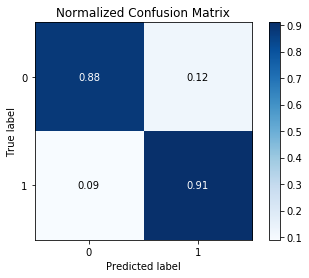

In [30]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(test_sentiments,predicted_sentiments, normalize=True)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

Count of Positive sentiment  25000
Count of negative sentimet  25000


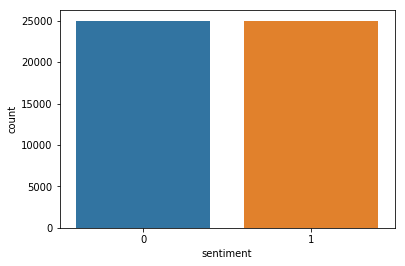

In [33]:
sns.countplot(data=df, x = 'sentiment', label='Count')

p, n = df['sentiment'].value_counts()
print('Count of Positive sentiment ',p)
print('Count of negative sentimet ',n)

